# Pytorch Basics


In [2]:
import torch
print(torch.__version__)

1.2.0


## Tensors

*   Pytorch [Tensors](https://pytorch.org/docs/1.1.0/tensors.html) are similar to numpy's ndarrays.
*    We can think of them as containers for data. The API for tensors generally follow that of ndarrays in numpy.


 Below is a 5 x 5 Tensor initialized uniformly at random [0, 1):


In [0]:
x = torch.rand(5,5)
print(x)

tensor([[0.2405, 0.5562, 0.8275, 0.7127, 0.2757],
        [0.9799, 0.0292, 0.0765, 0.5585, 0.4372],
        [0.2410, 0.2849, 0.9694, 0.7387, 0.1026],
        [0.6880, 0.8305, 0.5951, 0.6878, 0.8575],
        [0.6339, 0.1031, 0.2598, 0.9189, 0.7674]])


##Parameters

*   A [parameter](https://pytorch.org/docs/1.1.0/nn.html?highlight=nn%20parameter#torch.nn.Parameter) is a wrapper over tensors. 
*   The segment below "wraps" the tensor as 
a Parameter. Notice that the console shows `requires_grad=True`.
*   We can access the original tensor object from a Parameter using the `.data` attribute.


In [0]:
theta_x = torch.nn.Parameter(x)
print("Parameter:\n", theta_x)
print("Paramter.data:\n", theta_x.data)

Parameter:
 Parameter containing:
tensor([[0.2405, 0.5562, 0.8275, 0.7127, 0.2757],
        [0.9799, 0.0292, 0.0765, 0.5585, 0.4372],
        [0.2410, 0.2849, 0.9694, 0.7387, 0.1026],
        [0.6880, 0.8305, 0.5951, 0.6878, 0.8575],
        [0.6339, 0.1031, 0.2598, 0.9189, 0.7674]], requires_grad=True)
Paramter.data:
 tensor([[0.2405, 0.5562, 0.8275, 0.7127, 0.2757],
        [0.9799, 0.0292, 0.0765, 0.5585, 0.4372],
        [0.2410, 0.2849, 0.9694, 0.7387, 0.1026],
        [0.6880, 0.8305, 0.5951, 0.6878, 0.8575],
        [0.6339, 0.1031, 0.2598, 0.9189, 0.7674]])



*   The `requires_grad` attribute indicates to pytorch that it should *track all operations* performed on this parameter.
For example, lets look at the result of a few operations performed upon a Tensor and a Parameter:

In [0]:
x = torch.rand(1) # We will use a "scalar" tensor for this example i.e. a tensor of dimension 1
print('1. tensor input:', x)
y = (4 * (x ** 2)) - (x ** 3)
print('2. tensor operation result:', y)
theta_x = torch.nn.Parameter(x)
print('3. parameter input:', theta_x)
theta_y = (4 * (theta_x ** 2)) - (theta_x ** 3)
print('4. parameter operation result:', theta_y)

1. tensor input: tensor([0.3373])
2. tensor operation result: tensor([0.4168])
3. parameter input: Parameter containing:
tensor([0.3373], requires_grad=True)
4. parameter operation result: tensor([0.4168], grad_fn=<SubBackward0>)


##Automatic Differentiation

*   Notice that `theta_y` contains the same numerical result but the object `theta_y` also has a `grad_fn` attribute. 
*   The `grad_fn` contains back-pointers to the history of all computations performed upon a parameter.
*   With this pytorch can perform automatic differentiation and give us the gradient $\frac{\partial y}{\partial x}$.
*   We can get pytorch to compute the gradient of this our function $y = 4x^2 - x^3$ by using the `.backward()` function call:
*  See [Autograd](https://pytorch.org/tutorials/beginner/former_torchies/autograd_tutorial.html) for more details

In [0]:
theta_y.backward()
print(theta_y)

tensor([0.4168], grad_fn=<SubBackward0>)


Where is the gradient? When we call `.backward()` on `theta_y` the gradients are for the input parameters i.e. `theta_x`. 
*    Pytorch stores the gradient within the Parameter object, we can view the gradient by using the `.grad` attribute:


In [0]:
print(theta_x.grad)

tensor([2.3573])


We can check that this is indeed the gradient, lets create a function that computes the gradient for `func` and call it `grad`:

In [0]:
def func(x):
  return (4 * (x ** 2)) - (x ** 3)

def grad(x):
  return (8 * x) - (3 * (x ** 2))

float_x = theta_x.item() #.item() gives a python float value of a pytorch scalar.
print(func(float_x))  
print(grad(float_x))
print('gradient with pytorch:', theta_x.grad.item())

0.41677825169136656
2.3572589043806147
gradient with pytorch: 2.3572587966918945


Pretty cool, right? The small differences are due to pytorch defaulting to 32bit floats. 


*   Note that when we call `.backward()` pytorch deallocates the backpointers, which means (by default) we can't repeat a `backward` calls without calling multiple `forward` calls. ( By `forward` we simply mean the sequence of operations that generated `theta_y`)

## Optimization
Automatic differentiation is, of course, very handy when we want to optimize a function. 


###Pure python optimization
We'll first try and find the min value for `func`  using our `grad` (see below).  We initialize `x=1.0` and take gradient steps to minimize `y`. 

Text(0.5, 1.0, 'Pure Python Optim')

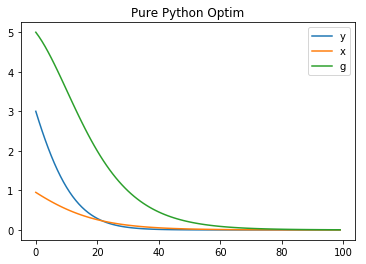

In [0]:
%matplotlib inline
import time
import pylab as pl
from IPython import display

def func(x):
  return (4 * (x ** 2)) - (x ** 3)

def grad(x):
  return (8 * x) - (3 * (x ** 2))

#list for plotting
ply =[]
plx = []
plg = []

#init value of param
x = 1.0

for _ in range(100):
  y = func(x)
  g = grad(x)
  x -= (g * 0.01)
  
  #for plot
  plx += [x]
  ply += [y]
  plg += [g]
  
pl.plot(ply)
pl.plot(plx)
pl.plot(plg)
pl.legend(['y', 'x' , 'g'])
pl.title('Pure Python Optim')

###Pytorch based optimization
Let's try and replicate this optimization using pytorch:

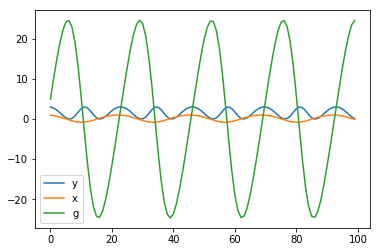

In [0]:
def pytorch_func(t_x):
  return (4 * (t_x ** 2)) - (t_x ** 3)

theta_x = torch.nn.Parameter(torch.Tensor([1.0]))
ply =[]
plx = []
plg = []
for _ in range(100):
  y = pytorch_func(theta_x)
  y.backward()
  g = theta_x.grad
  theta_x.data -= (g* 0.01)
  #adding values of parameter theta_x, output y and gradient g to lists for plotting.
  plg += [g.item()]
  plx += [theta_x.data.item()]
  ply += [y.item()]
  
pl.plot(ply)
pl.plot(plx)
pl.plot(plg)
pl.legend(['y', 'x', 'g'])

Yikes! The output does not look like what we got form the pure python implementation! What went wrong? 

The problem lies in not *reseting* the gradient. When the gradient is applied to the parameter (i.e. when a gradient update is made) we must tell pytorch to clear the gradients. We can do so by adding `theta_x.grad = None` after a gradient step has been applied. 

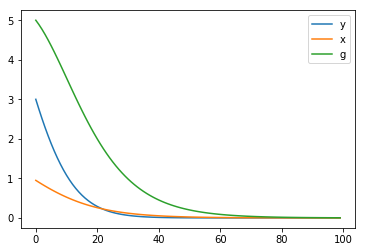

In [0]:
theta_x = torch.nn.Parameter(torch.Tensor([1.0]))
ply =[]
plx = []
plg = []
for _ in range(100):
  y = pytorch_func(theta_x)
  y.backward()
  g = theta_x.grad
  theta_x.data -= (g* 0.01)
  theta_x.grad = None # <-- clearing out old gradients
  #adding values of parameter theta_x, output y and gradient g to lists for plotting.
  plg += [g.item()]
  plx += [theta_x.data.item()]
  ply += [y.item()]
pl.plot(ply)
pl.plot(plx)
pl.plot(plg)
pl.legend(['y', 'x', 'g'])

## Modules
Modules form the "building blocks" of neural networks in pytorch. We can think of them as wrappers for Parameters along with a pre-defined `forward` and `backward` computation. Instead of using our `pytorch_func(theta_x)` in the previous section, we can wrap the Parameter `theta_x` and the forward function `pytorch_func` into a single `Module`.


In [0]:
class MyModule(torch.nn.Module):
  def __init__(self, init_param):
    super().__init__()
    self.theta_x = torch.nn.Parameter(torch.Tensor([init_param]))
  
  def forward(self,):
    return (4 * (self.theta_x ** 2)) - (self.theta_x ** 3)

Pytorch lets us call the `forward` computation of a Module by using the following shorthand:

In [0]:
my_mod = MyModule(1.0)
theta_y = my_mod() # this calls the forward function in MyModule
print(theta_y)

tensor([3.], grad_fn=<SubBackward0>)


Modules also have some handy functions built-in, one useful function is `.parameters()` which returns a generator of all parameters in the module:

In [0]:
for idx, (name_p, p) in enumerate(my_mod.named_parameters()):
  print(idx, 'name', name_p)
  print(idx, 'parameter', p)

0 name theta_x
0 parameter Parameter containing:
tensor([1.], requires_grad=True)


Just like before we can optimize using a module:

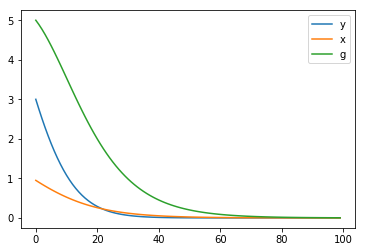

In [0]:
ply = []
plx = []
plg = []
for _ in range(100):
  y = my_mod()
  y.backward()
  g = my_mod.theta_x.grad
  my_mod.theta_x.data -= (g* 0.01)
  my_mod.theta_x.grad = None # <-- clearing out old gradients
  #adding values of parameter theta_x, output y and gradient g to lists for plotting.
  plg += [g.item()]
  plx += [my_mod.theta_x.data.item()]
  ply += [y.item()]
pl.plot(ply)
pl.plot(plx)
pl.plot(plg)
pl.legend(['y', 'x', 'g'])

## Building a simple Classifier

In supervised machine learning, we typically want to learn parameters `theta` that make our model learn mappings from some input `x` to some output `y`. We'll consider a simple classification task to illustrate how we can use modules and parameters in pytorch.

In the next segment we will use Modules to construct different compoments of our classifier. 
* First we'll implement a Linear layer which performs an affine transform of the input:

In [0]:
class MyLinear(torch.nn.Module):
  def __init__(self, num_inp, num_out):
    super().__init__()
    self.num_inp = num_inp
    self.num_out = num_out
    theta = torch.zeros(self.num_inp, self.num_out)
    theta.uniform_(-1.0, 1.0)
    self.theta = torch.nn.Parameter(theta)
    bias = torch.zeros(1, self.num_out)
    self.bias = torch.nn.Parameter(bias)
   

  def forward(self, x):
    #x shape should be (1, num_inp)
    _x = torch.mm(x, self.theta) # _x shape should be (1, num_out)
    _x = _x + self.bias # _x shape should be (1, num_out)
    return _x


*  Next, we'll create a sigmoid module and a binary cross entropy loss module.
Note that these modules don't contain any parameters (like `self.theta` or `self.bias` in our Linear layer above).

In [0]:
class MySigmoid(torch.nn.Module):
  def __init__(self,):
    super().__init__()
  
  def forward(self, x):
    return 1.0 / (1.0 + torch.exp(-x))

class MyLoss(torch.nn.Module):
  def __init__(self):
    super().__init__()
  
  def forward(self, y_hat, y):
    #y_hat and y should have the same shape
    _l = y * torch.log(y_hat) + (1.0 - y) * torch.log(1.0 - y_hat)
    return -_l

* Finaly we can create a new Module using the previous modules. The new Module defines our Classifier: 

In [0]:
class MyClassifier(torch.nn.Module):
  def __init__(self, num_inp):
    super().__init__()
    self.linear = MyLinear(num_inp=2, num_out=1)
    self.sig = MySigmoid()
    self.loss = MyLoss()
  
  def forward(self, x, y=None):
    _x = self.linear(x)
    y_hat = self.sig(_x)
    if y is None:
      loss = None
    else:
      loss = self.loss(y_hat, y)
    return y_hat, loss

* Let's create some data that we'd like our classifier to train on

In [0]:
data = []
for i in range(100):
  s1 =  (torch.randn((1, 2)) + torch.Tensor([[0.0, 0.0]]))
  s2 =  (torch.randn((1, 2)) + torch.Tensor([[3.0, 3.0]]))
  s3 =  (torch.randn((1, 2)) + torch.Tensor([[0.0, 3.0]]))
  s4 =  (torch.randn((1, 2)) + torch.Tensor([[3.0, 0.0]]))
  data += [(s1, torch.Tensor([0.0])),
           (s2, torch.Tensor([0.0])), 
           (s3, torch.Tensor([1.0])),
           (s4, torch.Tensor([1.0]))]
data = [(idx, x, y) for idx, (x,y) in enumerate(data)]

* Now we can train our classifier using SGD.
* Instead of writing our training loop repeatedly, we'll make a `train` method that accepts a classifier and our data.

In [0]:
import random
import numpy as np
def train(classifier, data, epochs=100):
  data = sorted(data)
  pll = []
  pla = []
  for e in range(100):
    random.shuffle(data)
    e_loss = []
    e_acc = []
    for idx, x, y in data:
      y_hat, loss = classifier(x, y)
      loss.backward()
      for p in classifier.parameters():
        p.data -= (p.grad * 0.01)
        p.grad = None
      e_loss.append(loss.item())
      if y.item() == 1.0:
        e_acc.append(1.0 if y_hat.item() > 0.5 else 0.0)
      else:
        e_acc.append(1.0 if y_hat.item() <= 0.5 else 0.0)
    pll.append(np.mean(e_loss))
    pla.append(np.mean(e_acc))
  pl.plot(pll)
  pl.plot(pla)
  pl.legend(['loss', 'acc'])

* Next, we'll create our classifier object and call the `train` method.

MyClassifier(
  (linear): MyLinear()
  (sig): MySigmoid()
  (loss): MyLoss()
)


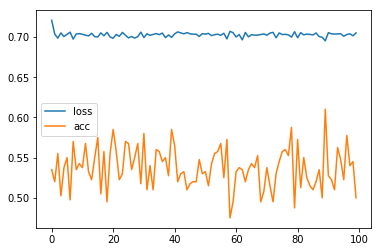

In [0]:
my_classifier = MyClassifier(2)
print(my_classifier)
train(my_classifier, data)

* Looks like our classifier is doing pretty badly. It achives a training accuracy of around 50%, pretty random.
* What if we make our model "deep" and stack more layers, We can easily do so by creating more objects of type `MyLinear`.

In [0]:
class MyDeepClassifier(torch.nn.Module):
  def __init__(self, num_inp):
    super().__init__()
    self.linear1 = MyLinear(num_inp=num_inp, num_out=3)
    self.linear2 = MyLinear(num_inp=3, num_out=1)
    self.sig = MySigmoid()
    self.loss = MyLoss()

  def forward(self, x, y=None):
    x = self.linear1(x)
    x = self.linear2(x)
    y_hat = self.sig(x)
    if y is None:
      loss = None
    else:
      loss = self.loss(y_hat, y)
    return y_hat, loss

MyDeepClassifier(
  (linear1): MyLinear()
  (linear2): MyLinear()
  (sig): MySigmoid()
  (loss): MyLoss()
)


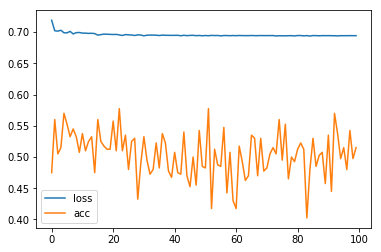

In [0]:
my_deep_classifier = MyDeepClassifier(2)
print(my_deep_classifier)
train(my_deep_classifier, data)

The above deep model, unfortunately, will still fail to do better than chance. Can you fix this?

In [0]:
class MyImprovedDeepClassifier(torch.nn.Module):
  def __init__(self, num_inp):
    super().__init__()
    self.linear1 = MyLinear(num_inp=num_inp, num_out=3)
    self.linear2 = MyLinear(num_inp=3, num_out=1)
    self.sig = MySigmoid()
    self.loss = MyLoss()

  def forward(self, x, y=None):
    x = self.linear1(x)
    x = self.linear2(self.sig(x))
    y_hat = self.sig(x)
    if y is None:
      loss = None
    else:
      loss = self.loss(y_hat, y)
    return y_hat, loss

MyImprovedDeepClassifier(
  (linear1): MyLinear()
  (linear2): MyLinear()
  (sig): MySigmoid()
  (loss): MyLoss()
)


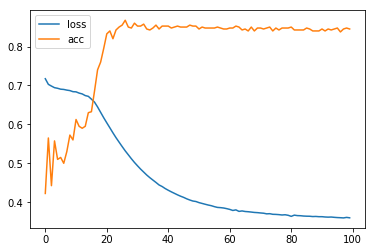

In [0]:
my_improved_deep_classifier = MyImprovedDeepClassifier(2)
print(my_improved_deep_classifier)
train(my_improved_deep_classifier, data)

## Built-In Pytorch Modules, Activations and Losses
In our Classifier, we constructed a Linear Layer, Sigmoid and Cross-Entropy Loss Modules but pytorch has all these ([and a lot more](https://pytorch.org/docs/stable/nn.html#containers)) built-in.

## Optimizers
In our examples above we have "manually" performed the gradient updates. While it is relatively simple for SGD it is inconvenient for more complex optimization algorithms such as ADAM and Adadelta.  Pytorch also has a host of optimiers.

We can re-write our optimization loop using pytorch's optimizer.

In [0]:
def train_with_optimizer(classifier, data, epoch=100, lr=0.01):
  optimizer  = torch.optim.SGD(classifier.parameters(), lr=lr)
  pll = []
  pla = []
  data = sorted(data)
  for e in range(epoch):
    random.shuffle(data)
    e_loss = []
    e_acc = []
    for _, x, y in data:
      optimizer.zero_grad()
      y_hat, loss = classifier(x, y)
      loss.backward()
      optimizer.step()
      e_loss.append(loss.item())
      y_hat[y_hat <= 0.5] = 0
      y_hat[y_hat > 0.5] = 1
      acc = (y_hat.long() == y.long()).sum().item() / y.numel()
      e_acc.append(acc)
      #if y.item() == 1.0:
      #  e_acc.append(1.0 if y_hat.item() > 0.5 else 0.0)
      #else:
      #  e_acc.append(1.0 if y_hat.item() <= 0.5 else 0.0)
    pll.append(np.mean(e_loss))
    pla.append(np.mean(e_acc))
  pl.plot(pll)
  pl.plot(pla)
  pl.legend(['loss', 'acc'])

MyImprovedDeepClassifier(
  (linear1): MyLinear()
  (linear2): MyLinear()
  (sig): MySigmoid()
  (loss): MyLoss()
)


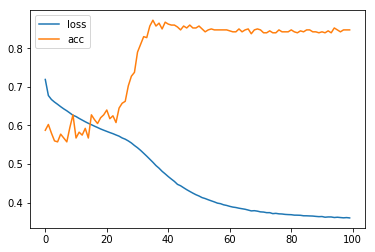

In [0]:
my_improved_deep_classifier = MyImprovedDeepClassifier(2)
print(my_improved_deep_classifier)
train_with_optimizer(my_improved_deep_classifier, data)

##CUDA
Finaly, we will see how to utilize the GPU efficiently. So far, all our computations were performed on the CPU. We can simply copy the model and the data to the GPU using the `.cuda()` function. Once this is done, the rest of the code can stay the same giving us GPU backed operations!

MyImprovedDeepClassifier(
  (linear1): MyLinear()
  (linear2): MyLinear()
  (sig): MySigmoid()
  (loss): MyLoss()
)


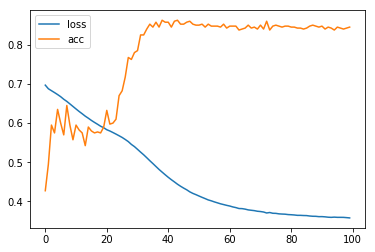

In [0]:
my_improved_deep_classifier = MyImprovedDeepClassifier(2)
my_improved_deep_classifier = my_improved_deep_classifier.cuda() # copy our model to the GPU
print(my_improved_deep_classifier)
cuda_data = [(i, x.cuda(), y.cuda()) for i, x, y in sorted(data)] # copy the data to the GPU
train_with_optimizer(my_improved_deep_classifier, cuda_data)

Was that any faster? 

It probably was not, because we did not take advantage of batching. Pytorch modules allow for batched computation, meaning we dont have to supply the model with 1 example at a time before computing the loss and the gradients. We can compute the loss for a "batch" of examples and optimize either the sum of the losses or (like in our case) the mean loss.

Below we reimplement the deep classifier with built-in pytorch modules.

In [0]:
class MyDeepClassifier_BuiltIn(torch.nn.Module):
  def __init__(self, num_inp):
    super().__init__()
    self.linear1 = torch.nn.Linear(num_inp, 3)
    self.linear2 = torch.nn.Linear(3, 1)
    self.linear1.weight.data.uniform_(-1.0, 1.0)
    self.linear1.bias.data.zero_()
    self.linear2.weight.data.uniform_(-1.0, 1.0)
    self.linear2.bias.data.zero_()
    self.sig = torch.nn.Sigmoid()
    self.loss = torch.nn.BCELoss()

  def forward(self, x, y=None):
    x = self.linear1(x)
    x = self.linear2(self.sig(x))
    y_hat = self.sig(x)
    if y is None:
      loss = None
    else:
      loss = self.loss(y_hat, y)
    return y_hat, loss

Next we are going to split up our data (400 examples) into 4 batches of 100 examples each. Note that we randomize the data before dividing them into batches. In the same loop, we can copy the data over to the GPU.

In [0]:
def batchify(data):
  batch_size = 100
  random.shuffle(data)
  batched_data_t = []
  for i in range(len(data) // batch_size):
    idx, xs, ys = zip(*data[i*batch_size:(i+1)*batch_size])
    xt = torch.cat(xs, dim=0)
    yt = torch.cat(ys, dim=0)
    yt = yt.unsqueeze(1)
    batched_data_t.append((i, xt.cuda(), yt.cuda()))
  return batched_data_t

Finally, we can learn the parameters of our Pytorch Classifier. This should run faster than our previous versions.

MyDeepClassifier_BuiltIn(
  (linear1): Linear(in_features=2, out_features=3, bias=True)
  (linear2): Linear(in_features=3, out_features=1, bias=True)
  (sig): Sigmoid()
  (loss): BCELoss()
)


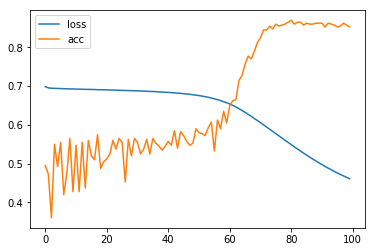

In [0]:
my_deep_classifier_builtin = MyDeepClassifier_BuiltIn(2)
my_deep_classifier_builtin = my_deep_classifier_builtin.cuda() # copy our model to the GPU
print(my_deep_classifier_builtin)
batched_data = batchify(data) #makes batches and copies the data over to the GPU
train_with_optimizer(my_deep_classifier_builtin, batched_data, epoch=100, lr=0.5)